# Cooke Triplet with Stock Lenses

Hemkumar Srinivas - May 2025

### 📘 Overview

In this notebook, we design a **Cooke Triplet** — a classic three-element photographic lens known for correcting **spherical**, **chromatic**, and **coma aberrations**. Our goal is to construct a working prototype using **off-the-shelf catalog lenses** from vendors such as **Thorlabs** and **Edmund Optics**.


In [1]:
import optiland.backend as be
from optiland import analysis, mtf, optic, psf, wavefront
from optiland import optimization

### 🔍 Simulating an Object at Infinity

To simulate an object located at **infinity**, we set the aperture type to `'EPD'` (Entrance Pupil Diameter). This configuration sends a bundle of **collimated rays** through the optical system, which mimics incoming light from a distant source.


In [2]:
lens = optic.Optic()
# add aperture
lens.set_aperture(aperture_type="EPD", value=10)

### 🔹 First Lens — Best-Form Convex (Thorlabs LBF254-040-A)

We begin with a **best-form positive lens** from Thorlabs — model **LBF254-040-A**. This lens is used as the **front element** of the Cooke Triplet to converge the incoming rays.


In [3]:
# first lens - best form convex lens
lens.add_surface(index=0, radius=be.inf, thickness=be.inf)
lens.add_surface(index=1, radius=24.02, thickness=6.5, material="N-BK7")
lens.add_surface(index=2, radius=-134.6, thickness=10)

### 🔹 Second Lens — Bi-Concave (Edmund Optics #45-929)

The middle element of the Cooke Triplet is a **negative (bi-concave) lens**. We'll use Edmund Optics lens **#45-929**, made of N-SF11 flint glass.

Since the optical stop is typically located within or near the second lens in this design, we’ll place the **stop on the second surface** of this lens.


In [4]:
lens.add_surface(index=3, radius=-31.82, thickness=2, material="N-SF11")
lens.add_surface(index=4, radius=31.82, thickness=10, is_stop=True)

### 🔹 Third Lens — Best-Form Convex (Again Thorlabs LBF254-040-A)

To complete the triplet, we reuse the same **best-form convex lens** (Thorlabs LBF254-040-A) as the **rear positive element**. This symmetric placement helps correct off-axis aberrations.


In [5]:
lens.add_surface(index=5, radius=134.6, thickness=6.5, material="N-BK7")
lens.add_surface(index=6, radius=-24.02, thickness=50)

In [6]:
# define surface for the image plane
lens.add_surface(index=7)

Now, let's define the fields and wavelengths over which we would like to analyse the system.

In [7]:
# add field
lens.set_field_type(field_type="angle")
lens.add_field(y=0)
lens.add_field(y=5)
lens.add_field(y=10)

# add wavelength
lens.add_wavelength(value=0.48)
lens.add_wavelength(value=0.55, is_primary=True)
lens.add_wavelength(value=0.65)

Let's see how the raytrace looks like.

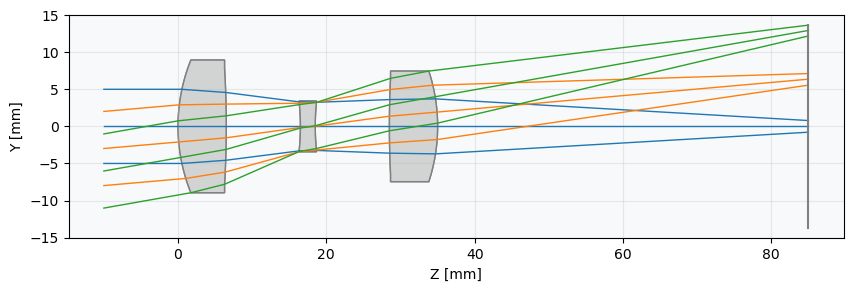

In [8]:
lens.draw()

Looks like we are not far away from the optimal configuratuion. We will now use the optimizer to find the best distances between the lenses. So, we define the optimization problem and the operands as follows. The system will be optimized at 550 nm wavelength.

In [9]:
problem = optimization.OptimizationProblem()

input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0,
    "num_rays": 5,
    "wavelength": 0.55,
    "distribution": "hexapolar",
}

# add RMS spot size operand
problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=1,
    input_data=input_data,
)

In [10]:
problem.add_variable(lens, "thickness", surface_number=2)
problem.add_variable(lens, "thickness", surface_number=4)
problem.add_variable(lens, "thickness", surface_number=6)

Define optimizer and run

In [11]:
optimizer = optimization.OptimizerGeneric(problem)
optimizer.optimize()

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.00029382874404814514
        x: [ 2.836e-01  1.297e-02  4.061e+00]
      nit: 2
      jac: [ 2.051e-05  5.413e-05 -4.469e-05]
     nfev: 16
     njev: 4
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Display results

In [12]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │            0.000293829 │           99.9225 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   0.017 │   0.017 │            100 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤═════════╤══════════════╤══════════════╕
│    │ Variable Type   │   Surface │   Value │ Min. Bound   │ Max. Bound   │
╞════╪═══════════════

Draw the final lens

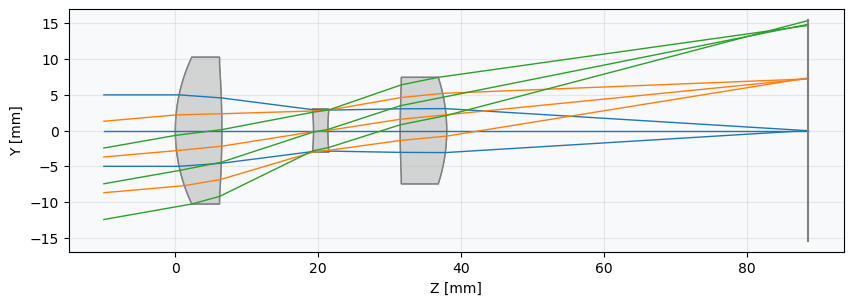

In [13]:
lens.draw()

Now, having optimized the distances between the lenses, we can look at the performance of the system : 

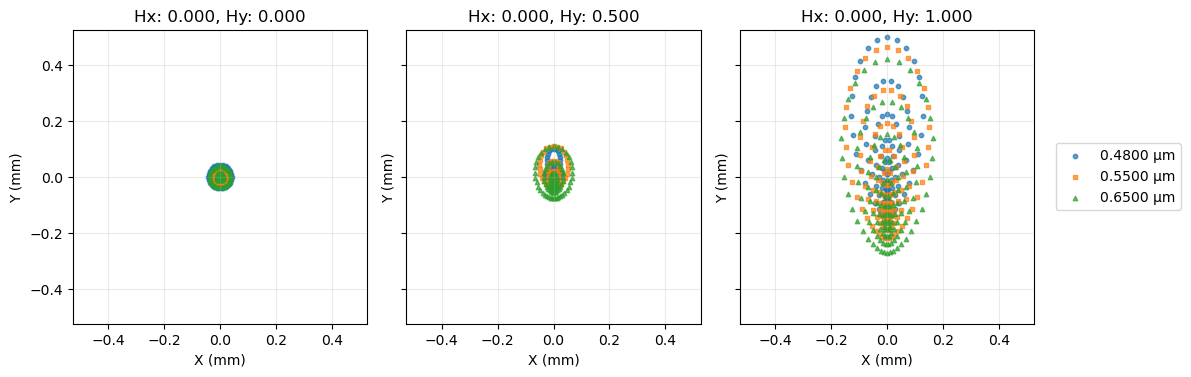

In [14]:
spot = analysis.SpotDiagram(lens)
spot.view()

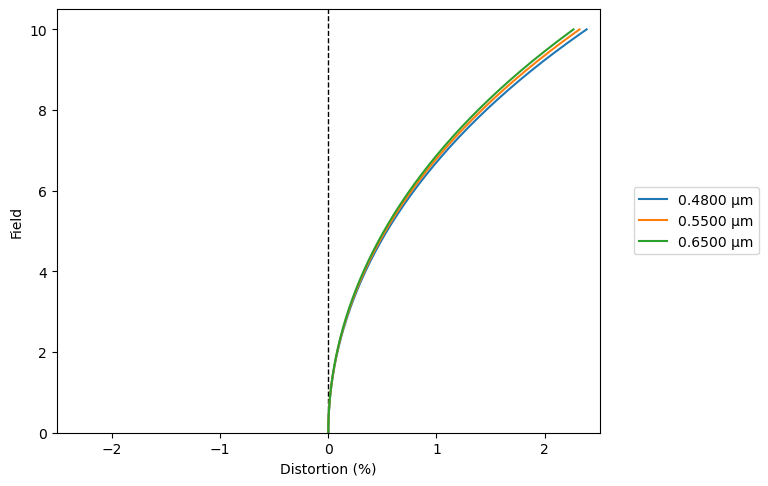

In [15]:
distortion = analysis.Distortion(lens)
distortion.view()

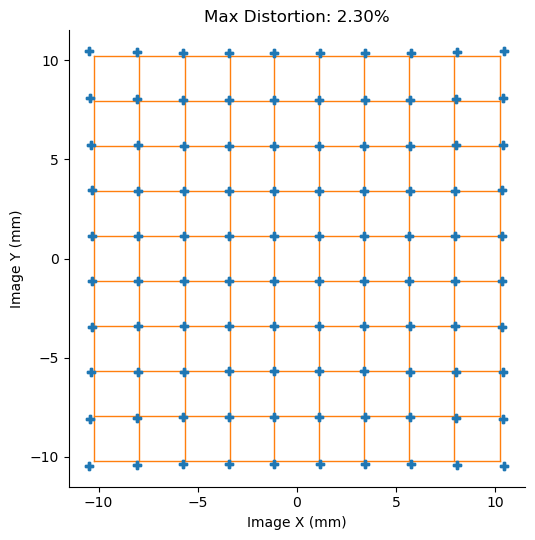

In [16]:
grid = analysis.GridDistortion(lens)
grid.view()

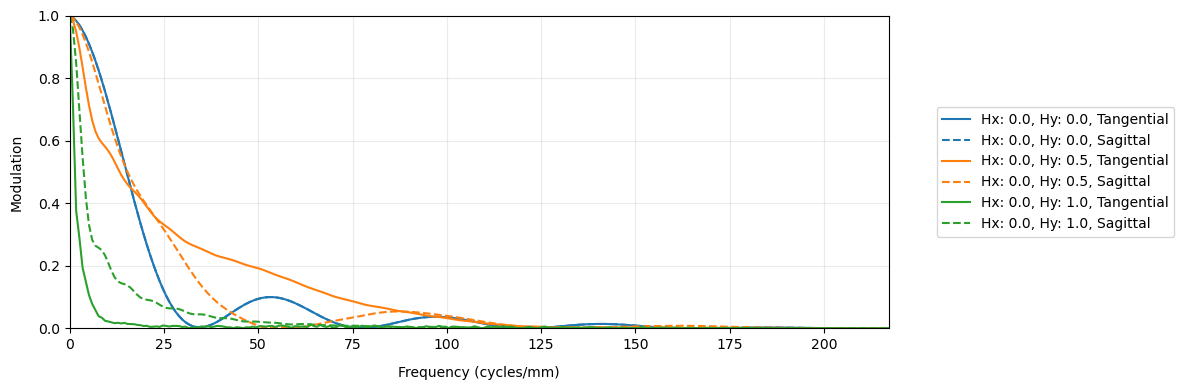

In [17]:
geo_mtf = mtf.GeometricMTF(lens)
geo_mtf.view()

To conclude, we have been able to construct a Cooke Triplet using simple off-the-shelf lenses. Together, these lenses could be mounted on cage systems from Thorlabs. The system seems to perform reasonably over a narrow field of view (about 5 degrees or less) and after this, it exhibits noticeable distortion. Nonetheless, this could be a quick DIY solution for some imaging needs in a lab (eg. Relay lens for a microscope, a compact projection system etc.)